In [1]:
import numpy as np # type: ignore
from matplotlib import pyplot as plt # type: ignore
from scipy import optimize # type: ignore
from scipy import integrate # type: ignore

---

### Integral calculation function

In [2]:
def gauss_integration(f, a, b):
    """Calculates the integral of f over [a, b] using Gauss-Legendre of 3rd degree."""
    x1, x2, x3 = -np.sqrt(0.6), 0, np.sqrt(0.6)
    w1, w2, w3 = 5/9, 8/9, 5/9

    def transform(t): return 0.5 * (b - a) * t + 0.5 * (b + a)
    integral = ((b - a) / 2) * (w1 * f(transform(x1)) + w2 *
                                f(transform(x2)) + w3 * f(transform(x3)))
    return integral

In [3]:
def simpson_integration(f, a, b):
    """Calculates the integral of f over [a, b] using Simpson's rule."""
    mid = (a + b) / 2
    return ((b - a) / 6) * (f(a) + 4 * f(mid) + f(b))

In [4]:
def fix_segments(a, b, eps):
    """Divides the interval [a, b] into equal parts of width approximately eps."""
    points = []
    x = a
    while x < b:
        points.append(x)
        x += eps
    points.append(b)
    return points

In [5]:

def recursive_divide(f, a, b, eps, depth, integral_type):
    """Divides the interval [a, b] recursively to achieve the desired precision."""
    if depth >= 50:
        if integral_type == 'simpson':
            return simpson_integration(f, a, b)
        if integral_type == 'gauss':
            return gauss_integration(f, a, b)

    mid = (a + b) / 2
    if integral_type == 'simpson':
        left_integral = simpson_integration(f, a, mid)
        right_integral = simpson_integration(f, mid, b)
        integral = simpson_integration(f, a, b)
    if integral_type == 'gauss':
        left_integral = gauss_integration(f, a, mid)
        right_integral = gauss_integration(f, mid, b)
        integral = gauss_integration(f, a, b)

    if abs((left_integral + right_integral) - integral) < eps:
        return left_integral + right_integral
    else:
        return (recursive_divide(f, a, mid, eps, depth + 1, integral_type) +
                recursive_divide(f, mid, b, eps, depth + 1, integral_type))

The main function:

In [6]:
def f_integral(f, a, b, eps, global_type, integral_type):
    """Calculates the integral of function f over [a, b] with specified precision."""
    if global_type == 'fix_segments':
        points = fix_segments(a, b, eps)
        if integral_type == 'simpson':
            integral = sum(simpson_integration(
                f, points[i], points[i+1]) for i in range(len(points) - 1))
        elif integral_type == 'gauss':
            integral = sum(gauss_integration(
                f, points[i], points[i+1]) for i in range(len(points) - 1))
        else:
            raise ValueError("Unknown integral type")
    elif global_type == 'recursive':
        max_depth = 50  
        if integral_type == 'simpson':
            integral = recursive_divide(
                f, a, b, eps, 0, integral_type)
        elif integral_type == 'gauss':
            integral = recursive_divide(
                f, a, b, eps, 0, integral_type)
        else:
            raise ValueError("Unknown integral type")
    else:
        raise ValueError("Unknown global type")

    return integral

Let's check the function with parabolic potential $V = x^2$. We know that $\int_{0}^{1} x^2dx = \frac{1}{3}$, so let's see how the results hold: 

In [7]:
def quadratic_potential(x):
    global integral_cnt
    integral_cnt += 1
    return x ** 2

a = 0  
b = 1  
eps_values = [1e-5, 1e-4, 1e-3, 1e-2]

global_types = ['fix_segments', 'recursive']
integral_types = ['simpson', 'gauss']  

print(f"{'Global Type':<15}{'Integral Type':<15}{'Eps':<10}{'Result':<25}{'Calls for function':<10}")
print("="*83)

for eps in eps_values:
    for gt in global_types:
        for it in integral_types:
            integral_cnt = 0
            result = f_integral(quadratic_potential, a, b, eps, gt, it)
            print(f"{gt:<15}{it:<15}{eps:<10}{result:<25.20f}{integral_cnt:<10}")
    print("-"*83)


Global Type    Integral Type  Eps       Result                   Calls for function
fix_segments   simpson        1e-05     0.33333333333333325932   300003    
fix_segments   gauss          1e-05     0.33333333333333325932   300003    
recursive      simpson        1e-05     0.33333333333333331483   9         
recursive      gauss          1e-05     0.33333333333333331483   9         
-----------------------------------------------------------------------------------
fix_segments   simpson        0.0001    0.33333333333333264870   30003     
fix_segments   gauss          0.0001    0.33333333333333270421   30003     
recursive      simpson        0.0001    0.33333333333333331483   9         
recursive      gauss          0.0001    0.33333333333333331483   9         
-----------------------------------------------------------------------------------
fix_segments   simpson        0.001     0.33333333333333348136   3000      
fix_segments   gauss          0.001     0.33333333333333348136  

### Explanation: 
We can see that we got very high precision using all methods - i needed to increase the accuracy from 10 to 20 digits after the point to see the difference. 

When looking at the calls to function: when comparing 'gauss' and simpson' we can see that they got the same amount of calls. This is reasonable, because inside the function itself we see three calls for $f$: f(transform($x_i$)) for Gauss integral, while Simpson method also has three calls for $a$, $b$ and $\frac{a+b}{2}$. 

When comparing 'fix_segments' and 'recursive' method, we can see that because the function that we gave ($x^2$) is smooth, the depth of recursion is low - it is always precise enough ($<eps$). I tried to enter more complex function, and seen the recursive method go up to 20 calls or so. In the contrary, the 'fix_segments' method is "straight forward" - so it makes a lot of function calls (constant amount for each segment).

---

### Root search function

In [8]:
def bisection(f, a, b, epsx, epsf):
    """Finds a root using the bisection method."""
    while (b - a) / 2 > epsx:
        midpoint = (a + b) / 2
        f_mid = f(midpoint)

        if abs(f_mid) < epsf:
            return midpoint
        elif np.sign(f(a)) == np.sign(f_mid):
            a = midpoint
        else:
            b = midpoint

    return (a + b) / 2

In [9]:
def secant(f, a, b, epsx, epsf):
    """Finds a root using the secant method with fallback to bisection."""
    x_0 = a
    x_1 = b
    while abs(x_1-x_0) > epsx or abs(f(x_1)) > epsf:
        if abs(x_1-x_0) > 0.8 * (b-a):
            if np.sign(f(x_0)) == np.sign(f((a+b)/2)):
                x_0 = (a+b)/2
            else:
                x_1 = (a+b)/2
        x_m = x_1 - f(x_1)*(x_1-x_0)/(f(x_1)-f(x_0))
        x_0 = x_1
        x_1 = min(max(a, x_m), b)  # normalize x1
    return x_1

The main function:

In [10]:
def x_root(f, a, b, epsx, epsf, type):
    """Finds a root of f in the interval [a, b] using the specified method."""

    if np.sign(f(a)) == np.sign(f(b)):
        raise ValueError(
            "Function values at the endpoints must have opposite signs.")

    if type == 'bisection':
        return bisection(f, a, b, epsx, epsf)
    elif type == 'secant':
        return secant(f, a, b, epsx, epsf)
    else:
        raise ValueError("Unknown method type. Use 'bisection' or 'secant'.")

Let's test the function using different $epsx$, $epsf$ and each type. Let's find roots of simple equation: $x^2 - 3 = 0$. The returned root should be $\sqrt{3}$, let's check the results:

In [11]:
def quadratic_potential(x):
    global root_cnt
    root_cnt += 1
    return x**2 - 3


a = 0  
b = 10 

eps_x_values = [1e-5, 1e-4, 1e-3]
eps_f_values = [1e-5, 1e-4, 1e-3]

types = ['bisection', 'secant']

print(f"{'Type':<15}{'Eps X':<15}{'Eps F':<10}{'Root':<20}{'Calls to function':<10}")
print("="*77)

for eps_x in eps_x_values:
    for eps_f in eps_f_values:
        for t in types:
            root_cnt = 0
            result = x_root(quadratic_potential, a, b, eps_x, eps_f, t)
            print(f"{t:<15}{eps_x:<15}{eps_f:<10}{result:<20.10f}{root_cnt:<10}")
        print("-"*77)

Type           Eps X          Eps F     Root                Calls to function
bisection      1e-05          1e-05     1.7320537567        40        
secant         1e-05          1e-05     1.7320508075        29        
-----------------------------------------------------------------------------
bisection      1e-05          0.0001    1.7320251465        33        
secant         1e-05          0.0001    1.7320508075        29        
-----------------------------------------------------------------------------
bisection      1e-05          0.001     1.7321777344        27        
secant         1e-05          0.001     1.7320508075        29        
-----------------------------------------------------------------------------
bisection      0.0001         1e-05     1.7321014404        34        
secant         0.0001         1e-05     1.7320508075        29        
-----------------------------------------------------------------------------
bisection      0.0001         0.0001    1.

### Explanation: 
Again, we see that the result differs for different $eps$ - both for $x$ and for $f(x)$. We can see that the secant method is more accurate than the regular bisection. Moreover, we see the similar pattern for $eps$ - the smaller eplsilon is, the more accurate is the function. It is easy to explain - we make more iterations in calculation and gain precision. 

Looking at the amount of calls - we can see that as $epsx$ and $epsf$ grow, the amount of calls goes down - this is because we need less precision - meaning less iterations.

---

### PART 3

Let's check the function for simple potential: $v(x) =x^2$ with $\gamma = 1$: 

In [12]:
def v_sq(x):
    global mone_v
    mone_v += 1  # counts how many times v was calculated for efficiency check
    return x*x


gamma = 1


def s(energy):
    global mone_s
    mone_s += 1  # counts how many times s was calculated for efficiency check
    x_1 = -np.sqrt(energy)
    x_2 = np.sqrt(energy)
    def ff(y): return np.sqrt(energy - v_sq(y))
    return gamma * f_integral(ff, x_1, x_2, 1e-6, 'recursive', 'gauss')


for n in range(5):
    def f(x): return s(x) - (n+0.5)*np.pi
    mone_v, mone_s = 0, 0
    e_n = x_root(f, 0, 1000, 1e-3, 1e-3, 'secant')
    print('%3d %20.16f %6d %4d %12.4e %12.4e' %
          (n, e_n, mone_v, mone_s, f(e_n), e_n/(2*n+1)-1))

  0   0.9999995879278104   5175   11  -2.6645e-13  -4.1207e-07
  1   2.9999995632605954   5391   11  -9.9476e-14  -1.4558e-07
  2   4.9999992721009923   5391   11  -1.6698e-13  -1.4558e-07
  3   6.9999996381740077   5607   11  -2.6645e-14  -5.1689e-08
  4   8.9999995347951511   5607   11  -3.7303e-14  -5.1689e-08


### Explanation: 
We got the results as expected: $\epsilon_{n} = 2n + 1, n = 0,1,2,3,4...$

---

### PART 4

### Second Order Approximation of Lennard-Jones Potential

Given the Lennard-Jones potential:
$ V(x) = 4 \left( \frac{1}{x^{12}} - \frac{1}{x^6} \right) $

##### 1. Find the Minimum

To find the minimum, we set the first derivative $V'(x)$ to zero.

The first derivative of $V(x)$ is:
$ V'(x) = 4 \left( -12 \frac{1}{x^{13}} + 6 \frac{1}{x^7} \right) = 4 \left( -\frac{12}{x^{13}} + \frac{6}{x^7} \right) $

Setting $V'(x) = 0$:
$ -\frac{12}{x^{13}} + \frac{6}{x^7} = 0 $

Solving for $x$:
$ \frac{6}{x^7} = \frac{12}{x^{13}} $
$ 6x^{13} = 12x^7 $
$ x^{13} = 2x^7 $
$ x^6 = 2 $
$ x = 2^{1/6} $

Thus, the minimum occurs at $x = 2^{1/6}$.

##### 2. Evaluate $V(x)$, $V'(x)$, and $V''(x)$ at $x = 2^{1/6}$

$ V \left( 2^{1/6} \right) = 4 \left( \frac{1}{(2^{1/6})^{12}} - \frac{1}{(2^{1/6})^6} \right) = 4 \left( \frac{1}{2^2} - \frac{1}{2^1} \right) = 4 \left( \frac{1}{4} - \frac{1}{2} \right) = 4 \left( \frac{1}{4} - \frac{2}{4} \right) = 4 \left( -\frac{1}{4} \right) = -1 $

We already know that $V'(x)$ at $x = 2^{1/6}$ is zero because it is the minimum.

For the second derivative:
$ V''(x) = 4 \left( 12 \cdot 13 \frac{1}{x^{14}} - 6 \cdot 7 \frac{1}{x^8} \right) = 4 \left( \frac{156}{x^{14}} - \frac{42}{x^8} \right) $

Evaluating at $x = 2^{1/6}$:
$ V'' \left( 2^{1/6} \right) = 4 \left( \frac{156}{(2^{1/6})^{14}} - \frac{42}{(2^{1/6})^8} \right) = 4 \left( \frac{156}{2^{14/6}} - \frac{42}{2^{8/6}} \right) = 4 \left( \frac{156}{2^{7/3}} - \frac{42}{2^{4/3}} \right) $

Simplifying the exponents:
$ = 4 \left( \frac{156}{2^{2 + 1/3}} - \frac{42}{2^{1 + 1/3}} \right) = 4 \left( \frac{156}{2^2 \cdot 2^{1/3}} - \frac{42}{2 \cdot 2^{1/3}} \right) $
$ = 4 \left( \frac{156}{4 \cdot 2^{1/3}} - \frac{42}{2 \cdot 2^{1/3}} \right) = 4 \left( \frac{39}{2^{1/3}} - \frac{21}{2^{1/3}} \right) $
$ = 4 \left( \frac{39 - 21}{2^{1/3}} \right) = 4 \left( \frac{18}{2^{1/3}} \right) = 4 \cdot 18 \cdot 2^{-1/3} $
$ = 72 \cdot 2^{-1/3} $

##### 3. Construct the Second-Order Taylor Series Expansion around $x = 2^{1/6}$

The Taylor series expansion is:
$ V(x) \approx V \left( 2^{1/6} \right) + V' \left( 2^{1/6} \right) (x - 2^{1/6}) + \frac{1}{2} V'' \left( 2^{1/6} \right) (x - 2^{1/6})^2 $

Substituting the values found:
$ V(x) \approx -1 + 0 \cdot (x - 2^{1/6}) + \frac{1}{2} \cdot 72 \cdot 2^{-1/3} \cdot (x - 2^{1/6})^2 $

Simplifying:
$ V(x) \approx -1 + 36 \cdot 2^{-1/3} \cdot (x - 2^{1/6})^2 $

Therefore, the second-order approximation for the Lennard-Jones potential $V(x)$ around $x = 2^{1/6}$ is:
$ V(x) \approx -1 + 36 \cdot 2^{-1/3} \cdot (x - 2^{1/6})^2 $


Now, let's check the results for the 2nd order approximation for Lennard-Jones potential: 

In [13]:
def v_hr(x):
    global mone_v
    mone_v += 1  # counts how many times v was calculated for efficiency check
    return -1 + (1/2) * (36/np.power(2, 1/3)) * (x - np.power(2, 1/6))**2


gamma = 150


def s(energy):
    global mone_s
    mone_s += 1  # counts how many times s was calculated for efficiency check

    def ff(x):
        return np.sqrt(energy - v_hr(x))

    x0 = np.power(2, 1/6)

    a = 1
    b = 2*x0
    c = (x0**2) * (1-(energy + 1)/36)

    x_1 = abs(((-b+np.sqrt(b**2-4*a*c))/2*a))
    x_2 = abs(((-b-np.sqrt(b**2-4*a*c))/2*a))

    return gamma * f_integral(ff, x_1, x_2, 1e-6, 'recursive', 'gauss')


en_hr = np.zeros(15)
m_v = np.zeros(14)
m_s = np.zeros(14)
f_n = np.zeros(14)

for n in range(14):
    def f(energy): return s(energy) - (n+0.5)*np.pi
    mone_v, mone_s = 0, 0
    en_hr[n] = x_root(f, -.999, -1e-7, 1e-3, 1e-3, 'secant')
    m_v[n], m_s[n], f_n[n] = mone_v, mone_s, f(en_hr[n])

print('%20.16f' % (2*(-1-en_hr[0])))

for n in range(14):
    print('%3d %20.16f %6d %4d %12.4e %20.16f' %
          (n, en_hr[n], m_v[n], m_s[n], f_n[n], en_hr[n]-en_hr[n+1]))

 -0.0615864442936362
  0  -0.9692067778531819    423   11  -1.9140e-13  -0.0615864442935820
  1  -0.9076203335595999    423   11  -3.4017e-12  -0.0615864442935591
  2  -0.8460338892660408    423   11  -7.8382e-12  -0.0615864442935226
  3  -0.7844474449725183    423   11  -1.4023e-11  -0.0615866898695492
  4  -0.7228607551029691    531   11  -5.8620e-14  -0.0615864988660071
  5  -0.6612742562369620    531   11   5.6843e-14  -0.0615864988660069
  6  -0.5996877573709551    531   11   3.5527e-15  -0.0615864988660066
  7  -0.5381012585049485    531   11   8.1712e-14  -0.0615864988660050
  8  -0.4765147596389435    585   11  -1.4211e-14  -0.0615864988660076
  9  -0.4149282607729359    585   11  -3.1974e-14  -0.0615864988660053
 10  -0.3533417619069306    585   11  -1.2079e-13  -0.0615864988660078
 11  -0.2917552630409228    585   11  -7.1054e-15  -0.0615864988660076
 12  -0.2301687641749152    585   11  -1.4211e-14  -0.0615864988660054
 13  -0.1685822653089098    585   11   1.4211e-14  -0.16

### Explanation:
We got the results, as expected they are less then 0 (left half plane) and of the relevant order of magnitude - let's see them in comparison to the roots that we get from the real potential and not an approximaion. 

---

### Part 5: 

Now let's calculate the roots for Lennard-Jones potential: $ V(x) = 4 \left( \frac{1}{x^{12}} - \frac{1}{x^6} \right) $ with $n=1...38$:

In [14]:
def v_lj(x):
    global mone_v
    mone_v += 1  # counts how many times v was calculated for efficiency check
    return 4 * ((1/x**12) - (1/x**6))


gamma = 150


def s(energy):
    global mone_s
    mone_s += 1  # counts how many times s was calculated for efficiency check

    def ff(x):
        return np.sqrt(energy - v_lj(x))

    # let's use np.roots function for finding the roots of the equation v(x) = e_n
    x_1, x_2 = sorted(np.power(np.roots([energy/4, 1, -1]), 1/6))

    return gamma * f_integral(ff, x_1, x_2, 1e-6, 'recursive', 'gauss')


en_lj = np.zeros(39)
m_v = np.zeros(38)
m_s = np.zeros(38)
f_n = np.zeros(38)

for n in range(38):
    def f(energy): return s(energy) - (n+0.5)*np.pi
    mone_v, mone_s = 0, 0
    en_lj[n] = x_root(f, -.999, -1e-7, 1e-3, 1e-3, 'secant')
    m_v[n], m_s[n], f_n[n] = mone_v, mone_s, f(en_lj[n])

print('%20.16f' % (2*(-1-en_hr[0])))

for n in range(38):
    print('%3d %20.16f %6d %4d %12.4e %20.16f' %
          (n, en_lj[n], m_v[n], m_s[n], f_n[n], en_lj[n]-en_lj[n+1]))

 -0.0615864442936362
  0  -0.9647666192501771   2565   17  -3.1653e-08  -0.0680924738641835
  1  -0.8966741453859937   2889   17  -5.9191e-07  -0.0649682240732239
  2  -0.8317059213127698   3051   17  -1.6538e-06  -0.0619024076465060
  3  -0.7698035136662638   3213   17  -2.3976e-06  -0.0588954422609312
  4  -0.7109080714053325   3321   17  -2.2402e-06  -0.0559476692505217
  5  -0.6549604021548108   3375   17  -1.3272e-06  -0.0530617835862928
  6  -0.6018986185685180   3375   17  -4.1721e-07  -0.0502404988986503
  7  -0.5516581196698677   2700   14   1.6178e-04  -0.0474748117810516
  8  -0.5041833078888160   2700   14   1.9759e-07  -0.0447782242749641
  9  -0.4594050836138519   4059   17  -2.4537e-04  -0.0421538809526211
 10  -0.4172512026612308   4950   20  -2.4109e-06  -0.0395848888690629
 11  -0.3776663137921679   5004   20  -2.2826e-05  -0.0370870209215680
 12  -0.3405792928706000   5058   20  -1.1562e-04  -0.0346566532859193
 13  -0.3059226395846807   5112   20  -4.1880e-04  -0.03

### Explanation: 
We can see that the results for $n = 1 ... 13 $ are similar to the results from the approximation (we will see the graph in the next part) and the rest are approaching zero. Let's plot the graph of the functions itself: 

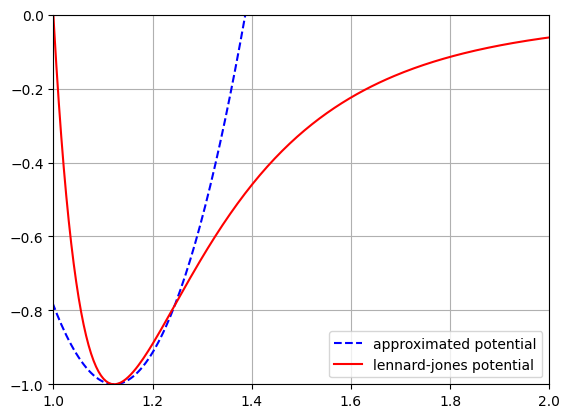

In [15]:
x = np.linspace(1e-9, 5, 1000)

hr = v_hr(x)
lj = v_lj(x)

plt.plot(x, hr, 'b--', label='approximated potential') 
plt.plot(x, lj, 'r', label='lennard-jones potential')  

plt.legend()
plt.grid(True)
ax = plt.gca()
ax.set_xlim([1, 2])
ax.set_ylim([-1, 0])
plt.show()

### Explanation: 
We can see that the coeeficients that I got for the approximated function slightly differ from the ones that are shown in the homework (the graph i got is slightly wider than the graph on page 2 of HW).

---

### Part 6: 

Now, let's compare the results from the original and approximated function: 

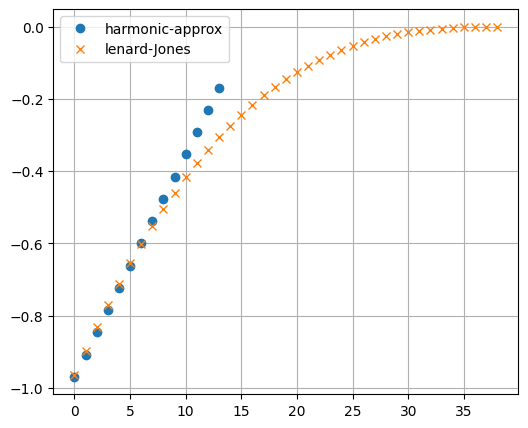

In [16]:
plt.figure(figsize=(6,5))
n1 = np.arange(14)
plt.plot(n1[:],en_hr[0:14],'o',label='harmonic-approx')
n2 = np.arange(39)
plt.plot(n2[:],en_lj[0:39],'x',label='lenard-Jones')
plt.grid()
plt.legend()
plt.show()

### Explanation: 
We can see that the roots differ slightly as expected (explained in the previous section), starting to differ around $n=10$, but overall are near the same. So, we can conclude that the approximation has good enough accuracy near the minimum point.

---

### Part 7:

Now, let's see how $eps$ value affects the accuracy of the algorithm: 

In [17]:
def v_lj(x):
    global mone_v
    mone_v += 1
    return 4 * ((1/x**12) - (1/x**6))


gamma = 150


def s(energy):
    global mone_s
    global ep
    mone_s += 1  # counts how many times s was calculated for efficiency check

    def ff(x):
        return np.sqrt(energy - v_lj(x))

    x_1, x_2 = sorted(np.power(np.roots([energy/4, 1, -1]), 1/6))

    return gamma * f_integral(ff, x_1, x_2, 1e4*ep, 'recursive', 'gauss')


n = 20
ep = 1e-3

print('bisection - recursive - gauss ')
print(' %3s %20s %12s %6s %4s %12s' %
      ('n', ' en_p ', ' ep ', 'it_v', 'it_s', ' err '))
for ip in range(10):
    def f(energy): return s(energy) - (n+0.5)*np.pi
    mone_v, mone_s = 0, 0
    en_p = x_root(f, -.999, -1e-7, ep, ep, 'secant')
    print(' %3d %20.16f %12.4e %6d %4d %12.4e' %
          (n, en_p, ep, mone_v, mone_s, f(en_p)))
    ep = ep/10

bisection - recursive - gauss 
   n                en_p           ep    it_v it_s         err 
  20  -0.1285024794137313   1.0000e-03    207   23   2.3365e-05
  20  -0.1285024794137313   1.0000e-04    207   23   2.3365e-05
  20  -0.1285026189204697   1.0000e-05    405   29  -1.1252e-09
  20  -0.1285026189137563   1.0000e-06    675   29  -7.8160e-13
  20  -0.1256870589790318   1.0000e-07   1503   29  -2.5102e-10
  20  -0.1253279258668270   1.0000e-08   3240   32  -1.4211e-14
  20  -0.1252531094694424   1.0000e-09   5760   32   1.4211e-14
  20  -0.1252468162344889   1.0000e-10   8568   32   0.0000e+00
  20  -0.1252464073266497   1.0000e-11  12096   32   1.4211e-14
  20  -0.1252463548286974   1.0000e-12  18999   35   0.0000e+00


### Explanation: 
As expected, the smaller value of $eps$ is, the bigger the amount of iterations needed for the result, and so the accuracty is higher. 

---

### Part 8:

Now let's use ready functions from scipy library to make the calculations: 

In [18]:
def v_lj(x):
    global mone_v
    mone_v += 1  # counts how many times v was calculated for efficiency check
    return 4 * ((1/x**12) - (1/x**6))


gamma = 150


def s(energy):
    global mone_s
    mone_s += 1  # counts how many times s was calculated for efficiency check

    def ff(x):
        return np.sqrt(energy - v_lj(x))

    x_1, x_2 = sorted(np.power(np.roots([energy/4, 1, -1]), 1/6))

    return gamma * integrate.quad(ff, x_1, x_2)[0]


en_lj = np.zeros(39)
m_v = np.zeros(38)
m_s = np.zeros(38)
f_n = np.zeros(38)

for n in range(38):
    def f(energy): return s(energy) - (n+0.5)*np.pi
    mone_v, mone_s = 0, 0
    en_lj[n] = optimize.brentq(f, -.999, -1e-7)
    m_v[n], m_s[n], f_n[n] = mone_v, mone_s, f(en_lj[n])

print('%20.16f' % (2*(-1-en_hr[0])))

for n in range(38):
    print('%3d %20.16f %6d %4d %12.4e %20.16f' %
          (n, en_lj[n], m_v[n], m_s[n], f_n[n], en_lj[n]-en_lj[n+1]))

 -0.0615864442936362
  0  -0.9647641336579037   3528    8   7.7716e-15  -0.0680925539603058
  1  -0.8966715796975979   3528    8   1.5099e-14  -0.0649681483389880
  2  -0.8317034313586099   3528    8   2.6645e-14  -0.0619019384444576
  3  -0.7698014929141523   3528    8   3.4461e-13  -0.0588948582067991
  4  -0.7109066347073533   3528    8   5.4179e-12  -0.0559478684086521
  5  -0.6549587662987012   3528    8  -4.8388e-12  -0.0530619573130643
  6  -0.6018968089856369   3927    9  -1.4211e-14  -0.0502381412468300
  7  -0.5516586677388069   3927    9  -1.1724e-13  -0.0474774651392010
  8  -0.5041812025996059   3927    9  -3.0553e-13  -0.0447810029916081
  9  -0.4594001996079977   3927    9  -1.4211e-12  -0.0421498582706246
 10  -0.4172503413373732   3927    9  -1.0708e-11  -0.0395851642044493
 11  -0.3776651771329239   3927    9   1.2392e-11  -0.0370880839596724
 12  -0.3405770931732514   4326   10   3.5527e-14  -0.0346598106863191
 13  -0.3059172824869323   4326   10  -2.8422e-14  -0.03

### Explanation:
As expected, the algorithms from the scipy library are more optimized so we get more accurate result. But, despite that, our result is fairly close to this, so we can conclude that the algorithms that we made are good.